<a name='0'></a>
## Imports

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import matplotlib.pyplot as plt

import helper_utils

In [4]:
# Load the dataset from the CSV file
file_path = './data/data_with_features.csv'
data_df = pd.read_csv(file_path)

# Print the shape of the DataFrame
print(f"Dataset Shape: {data_df.shape}\n")

Dataset Shape: (100, 4)



In [6]:
print(data_df.head(10))

   distance_miles  time_of_day_hours  is_weekend  delivery_time_minutes
0            1.60               8.20           0                   7.22
1           13.09              16.80           1                  32.41
2            6.97               8.02           1                  17.47
3           10.66              16.07           0                  37.17
4           18.24              13.47           0                  38.36
5            5.74              16.59           0                  29.06
6            8.80              12.25           0                  23.94
7           15.36              11.76           1                  32.40
8            5.35               9.42           0                  17.06
9            2.46              14.44           0                  14.09


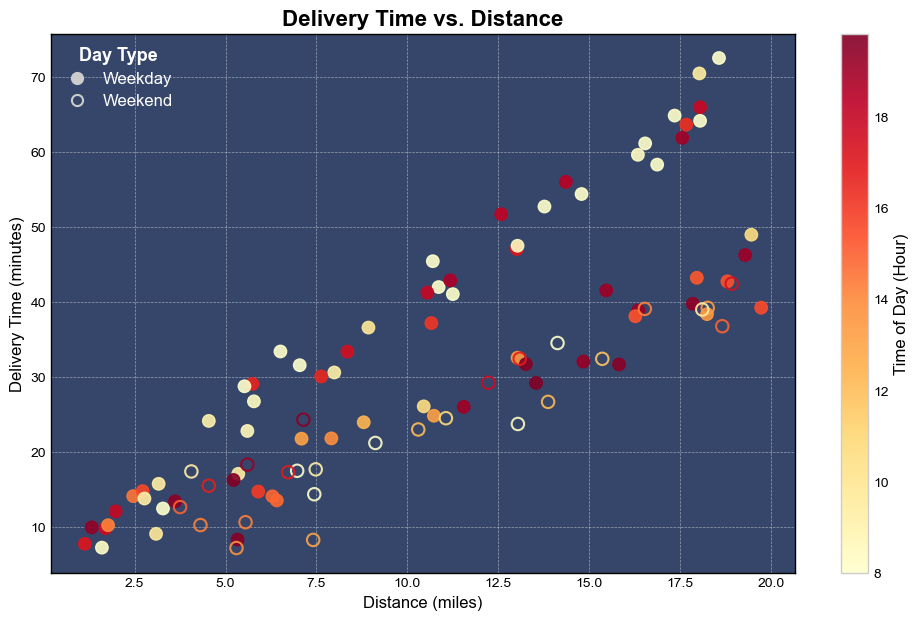

In [7]:
helper_utils.plot_delivery_data(data_df)

In [8]:
# Define the 5 rows of data as a single 2D tensor
sample_tensor = torch.tensor([
    # distance, time_of_day, is_weekend, delivery_time
    [1.60,      8.20,        0,          7.22],   # row 1
    [13.09,     16.80,       1,          32.41],  # row 2       
    [6.97,      8.02,        1,          17.47],  # row 3
    [10.66,     16.07,       0,          37.17],  # row 4
    [18.24,     13.47,       0,          38.36]   # row 5
], dtype=torch.float32)

In [9]:

sample_hours = sample_tensor[:, 1]
sample_weekends = sample_tensor[:, 2]

print("--- Sliced Tensors ---")
print(f"Sample Hours:    {sample_hours}")
print(f"Sample Weekends: {sample_weekends}\n")

--- Sliced Tensors ---
Sample Hours:    tensor([ 8.2000, 16.8000,  8.0200, 16.0700, 13.4700])
Sample Weekends: tensor([0., 1., 1., 0., 0.])



In [10]:

def rush_hour_feature(hours_tensor, weekends_tensor):
    """
    Engineers a new binary feature indicating if a delivery is in a weekday rush hour.

    Args:
        hours_tensor (torch.Tensor): A tensor of delivery times of day.
        weekends_tensor (torch.Tensor): A tensor indicating if a delivery is on a weekend.

    Returns:
        torch.Tensor: A tensor of 0s and 1s indicating weekday rush hour.
    """
    
    # Define rush hour and weekday conditions
    is_morning_rush = (hours_tensor >= 8.0) & (hours_tensor < 10.0)
    is_evening_rush = (hours_tensor >= 16.0) & (hours_tensor < 19.0)
    is_weekday = (weekends_tensor == 0)

    # Combine the conditions to create the final rush hour mask
    is_rush_hour_mask = is_weekday & (is_morning_rush | is_evening_rush)

    # Convert the boolean mask to a float tensor to use as a numerical feature
    return is_rush_hour_mask.float()

In [11]:
rush_hour_for_sample = rush_hour_feature(sample_hours, sample_weekends)

print(f"Sample Hours:     {sample_hours.numpy()}")
print(f"Sample Weekends:  {sample_weekends.numpy()}")
print(f"Is Rush Hour?:    {rush_hour_for_sample.numpy()}")

Sample Hours:     [ 8.2  16.8   8.02 16.07 13.47]
Sample Weekends:  [0. 1. 1. 0. 0.]
Is Rush Hour?:    [1. 0. 0. 1. 0.]


In [12]:
# GRADED FUNCTION: prepare_data

def prepare_data(df):
    """
    Converts a pandas DataFrame into prepared PyTorch tensors for modeling.

    Args:
        df (pd.DataFrame): A pandas DataFrame containing the raw delivery data.

    Returns:
        prepared_features (torch.Tensor): The final 2D feature tensor for the model.
        prepared_targets (torch.Tensor): The final 2D target tensor.
        results_dict (dict): A dictionary of intermediate tensors for testing purposes.
    """

    # Extract the data from the DataFrame as a NumPy array
    # (There's no direct torch.from_dataframe(), so we use .values to get a NumPy array first)
    all_values = df.values

    # Convert all the values from the DataFrame into a single PyTorch tensor
    full_tensor = torch.tensor(all_values, dtype=torch.float32)

    # Use tensor slicing to separate out each raw column
    raw_distances = full_tensor[:, 0]
    raw_hours = full_tensor[:, 1]
    raw_weekends = full_tensor[:, 2]
    raw_targets = full_tensor[:, 3]

    # Call your rush_hour_feature() function to engineer the new feature
    is_rush_hour_feature = rush_hour_feature(raw_hours, raw_weekends)

    # Use the .unsqueeze(1) method to reshape the four 1D feature tensors into 2D column vectors
    distances_col = raw_distances.unsqueeze(1)
    hours_col =raw_hours.unsqueeze(1)
    weekends_col = raw_weekends.unsqueeze(1)
    rush_hour_col = is_rush_hour_feature.unsqueeze(1)

    # Normalize the continuous feature columns (distance and time)
    dist_mean, dist_std = distances_col.mean(), distances_col.std()
    hours_mean, hours_std = hours_col.mean(), hours_col.std()
 
    distances_norm = (distances_col - dist_mean) / dist_std
    hours_norm = (hours_col - hours_mean) / hours_std

    # Combine all prepared 2D features into a single tensor
    prepared_features = torch.cat([
        distances_norm,
        hours_norm,
        weekends_col,
        rush_hour_col
    ], dim=1) # dim=1 concatenates them column-wise, stacking features side by side

    # Prepare targets by ensuring they are the correct shape
    prepared_targets = raw_targets.unsqueeze(1)
    
    # Dictionary for Testing Purposes
    results_dict = {
        'full_tensor': full_tensor,
        'raw_distances': raw_distances,
        'raw_hours': raw_hours,
        'raw_weekends': raw_weekends,
        'raw_targets': raw_targets,
        'distances_col': distances_col,
        'hours_col': hours_col,
        'weekends_col': weekends_col,
        'rush_hour_col': rush_hour_col
    }
    

    return prepared_features, prepared_targets, results_dict

In [13]:
# Create a small test DataFrame with the first 5 entries
test_df = data_df.head(5).copy()

# Print the "Before" state as a raw tensor
raw_test_tensor = torch.tensor(test_df.values, dtype=torch.float32)
print("--- Raw Tensor (Before Preparation) ---\n")
print(f"Shape: {raw_test_tensor.shape}")
print("Values:\n", raw_test_tensor)
print("\n" + "="*50 + "\n")

# Run the function to get the prepared "after" tensors
test_features, test_targets, _ = prepare_data(test_df)

# Print the "After" state
print("--- Prepared Tensors (After Preparation) ---")
print("\n--- Prepared Features ---\n")
print(f"Shape: {test_features.shape}")
print("Values:\n", test_features)

print("\n--- Prepared Targets ---")
print(f"Shape: {test_targets.shape}")
print("Values:\n", test_targets)

--- Raw Tensor (Before Preparation) ---

Shape: torch.Size([5, 4])
Values:
 tensor([[ 1.6000,  8.2000,  0.0000,  7.2200],
        [13.0900, 16.8000,  1.0000, 32.4100],
        [ 6.9700,  8.0200,  1.0000, 17.4700],
        [10.6600, 16.0700,  0.0000, 37.1700],
        [18.2400, 13.4700,  0.0000, 38.3600]])


--- Prepared Tensors (After Preparation) ---

--- Prepared Features ---

Shape: torch.Size([5, 4])
Values:
 tensor([[-1.3562, -1.0254,  0.0000,  1.0000],
        [ 0.4745,  1.0197,  1.0000,  0.0000],
        [-0.5006, -1.0682,  1.0000,  0.0000],
        [ 0.0873,  0.8461,  0.0000,  1.0000],
        [ 1.2951,  0.2278,  0.0000,  0.0000]])

--- Prepared Targets ---
Shape: torch.Size([5, 1])
Values:
 tensor([[ 7.2200],
        [32.4100],
        [17.4700],
        [37.1700],
        [38.3600]])


In [14]:
# Process the entire DataFrame to get the final feature and target tensors.
features, targets, _ = prepare_data(data_df)

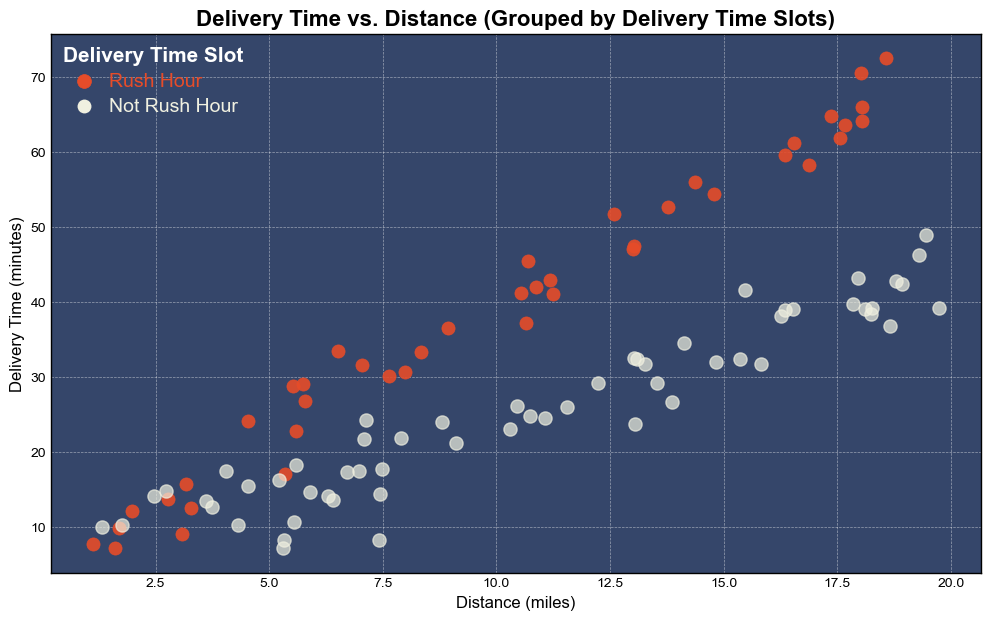

In [15]:
helper_utils.plot_rush_hour(data_df, features)

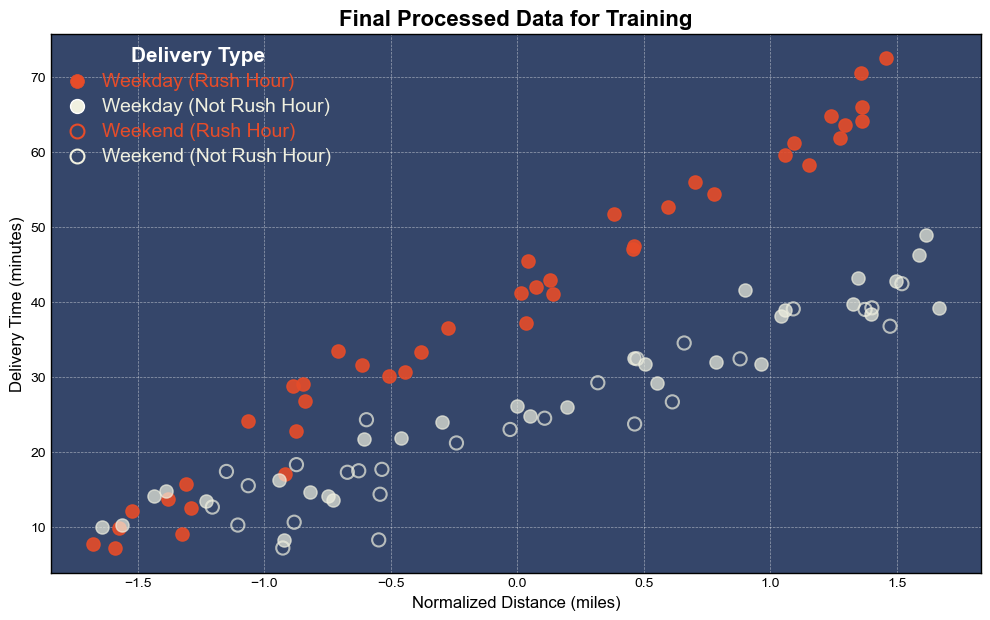

In [16]:
helper_utils.plot_final_data(features, targets)

In [18]:
# GRADED FUNCTION: init_model

def init_model():
    """
    Initializes the neural network model, optimizer, and loss function.

    Returns:
        model (nn.Sequential): The initialized PyTorch sequential model.
        optimizer (torch.optim.Optimizer): The initialized optimizer for training.
        loss_function: The initialized loss function.
    """

    # Set the random seed for reproducibility of results (DON'T MANIPULATE IT)
    torch.manual_seed(41)


    # Define the model architecture using nn.Sequential
    model = nn.Sequential(
        # Input layer (Linear): 4 input features, 64 output features
        nn.Linear(in_features=4, out_features=64),
        # First ReLU activation function
        nn.ReLU(),
        # Hidden layer (Linear): 64 inputs, 32 outputs
        nn.Linear(in_features=64, out_features=32),
        # Second ReLU activation function
        nn.ReLU(),
        # Output layer (Linear): 32 inputs, 1 output (the prediction)
        nn.Linear(in_features=32, out_features=1)
    ) 
    
    # Define the optimizer (Stochastic Gradient Descent)
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Define the loss function (Mean Squared Error for regression)
    loss_function = nn.MSELoss()

    return model, optimizer, loss_function

In [19]:
model, optimizer, loss_function = init_model()

print(f"{'='*30}\nInitialized Model Architecture\n{'='*30}\n{model}")
print(f"\n{'='*30}\nOptimizer\n{'='*30}\n{optimizer}")
print(f"\n{'='*30}\nLoss Function\n{'='*30}\n{loss_function}")

Initialized Model Architecture
Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)

Optimizer
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

Loss Function
MSELoss()


In [20]:
def train_model(features, targets, epochs, verbose=True):
    """
    Trains the model using the provided data for a number of epochs.
    
    Args:
        features (torch.Tensor): The input features for training.
        targets (torch.Tensor): The target values for training.
        epochs (int): The number of training epochs.
        verbose (bool): If True, prints training progress. Defaults to True.
        
    Returns:
        model (nn.Sequential): The trained model.
        losses (list): A list of loss values recorded every 5000 epochs.
    """
    
    # Initialize a list to store the loss
    losses = []
    
    # Initialize the model, optimizer, and loss function using `init_model`
    model, optimizer, loss_function = init_model()

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        
        # Forward pass: Make predictions
        outputs = model(features)

        # Calculate the loss
        loss = loss_function(outputs, targets)

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass: Compute gradients
        loss.backward()

        # Update the model's parameters
        optimizer.step()
    
        # Every 5000 epochs, record the loss and print the progress
        if (epoch + 1) % 5000 == 0:
            losses.append(loss.item())
            if verbose:
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model, losses

In [21]:
test_model, loss = train_model(features, targets, 10000)

Epoch [5000/10000], Loss: 4.3202
Epoch [10000/10000], Loss: 1.7398


In [22]:
# Training loop
model, loss = train_model(features, targets, 30000)

Epoch [5000/30000], Loss: 4.3202
Epoch [10000/30000], Loss: 1.7398
Epoch [15000/30000], Loss: 1.0605
Epoch [20000/30000], Loss: 0.8506
Epoch [25000/30000], Loss: 0.9309
Epoch [30000/30000], Loss: 0.4355


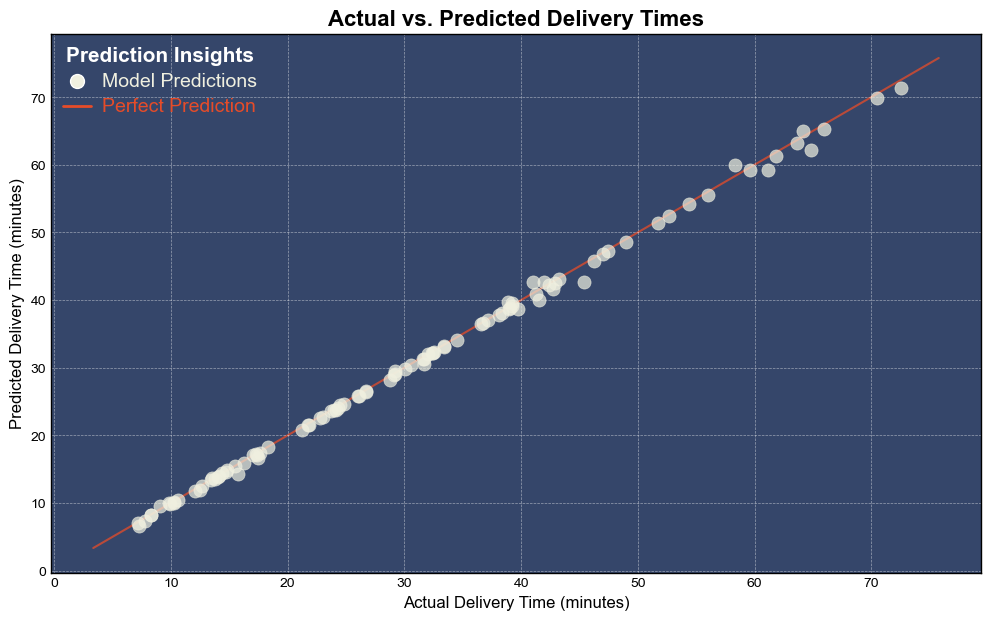

In [23]:
# Disable gradient calculation for efficient predictions
with torch.no_grad():
    # Perform a forward pass to get model predictions
    predicted_outputs = model(features)

# Plot predictions vs. actual targets to evaluate performance
helper_utils.plot_model_predictions(predicted_outputs, targets)

In [24]:
# EDITABLE CELL: Set your values below

# Change the values below to get an estimate for a different delivery
# Set distance for the delivery in miles
distance_miles = 20
# Set time of day in 24-hour format (e.g., 9.5 for 9:30 AM)
time_of_day_hours = 14
# Use True/False or 1/0 to indicate if it's a weekend
is_weekend = True

# Convert the raw inputs into a 2D tensor for the model
raw_input_tensor = torch.tensor([[distance_miles, time_of_day_hours, is_weekend]], dtype=torch.float32)

Now, you'll pass your trained `model`, the original `data_df`, your `raw_input_tensor`, and the `rush_hour_feature` function to the helper function. This will process your new inputs and use the model to generate the estimated delivery time.

In [25]:
helper_utils.prediction(model, data_df, raw_input_tensor, rush_hour_feature)

+------------------------------------------+-----------------------+
|                         Model Prediction                         |
+------------------------------------------+-----------------------+
| Time of the Week                         | Weekend               |
| Distance                                 | 20.0 miles            |
| Time                                     | 14:00                 |
| Is this considered a rush hour period?   | No                    |
+------------------------------------------+-----------------------+
| Estimated Delivery Time                  | 39.39 minutes         |
+------------------------------------------+-----------------------+
